##Import Packages

In [90]:
!pip install category_encoders
!pip install pdpbox
!pip install shap

##Import Libraries

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_interact, pdp_interact_plot

##Wrangle Data

In [92]:
df = pd.read_csv('vehicles.csv')

def wrangle(df):
  #Rplace misworded column values to reflect correct value
  df['fuelType'].replace({'Regular Gas or Electricity':'Regular Gas and Electricity'}, inplace=True)
  
  #Adjust Greenhouse gas score
  df['ghgScore'].replace(-1, 0, inplace=True)
  
  #Reclass start stop option to binary classification
  df['startStop'] = df['startStop'].apply(lambda x: 1 if x == 'Y' else 0)
  
  #Define columns to be used after EDA
  df = df[['ghgScore', 'year', 'cylinders',
          'drive','trany', 'startStop',
          'fuelType','VClass']]

  #Rename Column for clarifcation
  df.rename(columns={'trany':'transmission'}, inplace=True)
  
  #Drop null values
  df.dropna(inplace=True)
  
  #Specify years used to avoid leakage
  df = df[df['year'] > 1999]
  
  return df

df = wrangle(df)

In [93]:
df.head()


,ghgScore,year,cylinders,drive,transmission,startStop,fuelType,VClass
6210,0,2000,6.0,Rear-Wheel Drive,Automatic 4-spd,0,Premium,Two Seaters
6212,0,2000,6.0,Rear-Wheel Drive,Manual 6-spd,0,Premium,Two Seaters
6213,0,2000,6.0,Rear-Wheel Drive,Manual 5-spd,0,Premium,Two Seaters
6214,0,2000,6.0,Rear-Wheel Drive,Automatic 4-spd,0,Premium,Two Seaters
6215,0,2000,6.0,Rear-Wheel Drive,Manual 5-spd,0,Premium,Two Seaters


##Check value counts to ensure target is evenly distributed.

In [94]:
df['fuelType'].value_counts()

Regular                        12533
Premium                        10256
Gasoline or E85                 1350
Diesel                           367
Midgrade                         130
Premium or E85                   127
Premium and Electricity           92
Regular Gas and Electricity       63
Premium Gas or Electricity        55
CNG                               47
Gasoline or natural gas           20
Gasoline or propane                8
Name: fuelType, dtype: int64

##Create target variable and feature matrix.

In [95]:
target = 'fuelType'

y=df[target]
X=df.drop(target, axis=1)

##Perform train test split of data.

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.8,
                                                  test_size = 0.2, random_state=42)

In [97]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.49910170675716137


##Logistic Regression

In [98]:
model_lr =make_pipeline(
     OrdinalEncoder(),
     LogisticRegression())

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['drive', 'transmission', 'VClass'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'drive',
                                          'data_type': dtype('O'),
                                          'mapping': Front-Wheel Drive             1
Rear-Wheel Drive              2
All-Wheel Drive               3
4-Wheel or All-Wheel Drive    4
4-Wheel Drive                 5
Part-time 4-Wheel Drive       6
2-Wheel Drive                 7
NaN                          -2
d...
Special Purpose Vehicles              25
Special Purpose Vehicle               26
NaN                                   -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=N

##Logistic Regression Score

In [99]:
print('Logistic Regression score:',model_lr.score(X_train, y_train))


Logistic Regression score: 0.5066373889609741


#Random forest classifier model

In [100]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=20, random_state=42)
)

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['drive', 'transmission', 'VClass'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'drive',
                                          'data_type': dtype('O'),
                                          'mapping': Front-Wheel Drive             1
Rear-Wheel Drive              2
All-Wheel Drive               3
4-Wheel or All-Wheel Drive    4
4-Wheel Drive                 5
Part-time 4-Wheel Drive       6
2-Wheel Drive                 7
NaN                          -2
d...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_sample

##Random forest traiing, validation and test score.


In [101]:
print('Random Forest Training Score:', model_rf.score(X_train, y_train))
print('Random Forest Validation Score:', model_rf.score(X_val, y_val))

Random Forest Training Score: 0.8940013973450445
Random Forest Validation Score: 0.8251497005988024


##Gradient boosting model

In [102]:
model_gb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    GradientBoostingClassifier(random_state=42)
)

model_gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['drive', 'transmission', 'VClass'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'drive',
                                          'data_type': dtype('O'),
                                          'mapping': Front-Wheel Drive             1
Rear-Wheel Drive              2
All-Wheel Drive               3
4-Wheel or All-Wheel Drive    4
4-Wheel Drive                 5
Part-time 4-Wheel Drive       6
2-Wheel Drive                 7
NaN                          -2
d...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
    

##Gradient boosting validation score

In [103]:
model_gb.score(X_val, y_val)

0.7988023952095809

##XGBoost model

In [104]:
model_xg = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_jobs=-1, random_state=42)
)

model_xg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['drive', 'transmission', 'VClass'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'drive',
                                          'data_type': dtype('O'),
                                          'mapping': Front-Wheel Drive             1
Rear-Wheel Drive              2
All-Wheel Drive               3
4-Wheel or All-Wheel Drive    4
4-Wheel Drive                 5
Part-time 4-Wheel Drive       6
2-Wheel Drive                 7
NaN                          -2
d...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                  

In [105]:
model_xg.score(X_val, y_val)

0.7960079840319362

In [106]:
model_rf.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['drive', 'transmission', 'VClass'], drop_invariant=False,
                handle_missing='value', handle_unknown='value',
                mapping=[{'col': 'drive', 'data_type': dtype('O'),
                          'mapping': Front-Wheel Drive             1
 Rear-Wheel Drive              2
 All-Wheel Drive               3
 4-Wheel or All-Wheel Drive    4
 4-Wheel Drive                 5
 Part-time 4-Wheel Drive       6
 2-Wheel Drive                 7
 NaN                          -2
 dtype: int64},
                         {'col': 'transmission', 'data_type':...
 Midsize Cars                          12
 Large Cars                            13
 Sport Utility Vehicle - 2WD           14
 Special Purpose Vehicle 2WD           15
 Small Pickup Trucks 2WD               16
 Standard Sport Utility Vehicle 2WD    17
 Small Pickup Trucks 4WD               18
 Small Station Wagons                  19
 Vans, Passenger Type                  20
 Midsize Sta

## Feature importances for Random Forest model

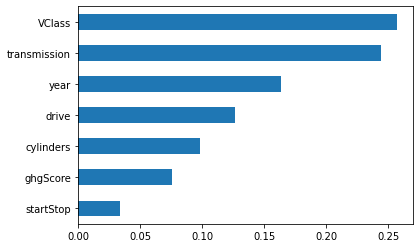

In [107]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns

feature_imp = pd.Series(importances, index=features).sort_values()
feature_imp.tail(10).plot(kind='barh')

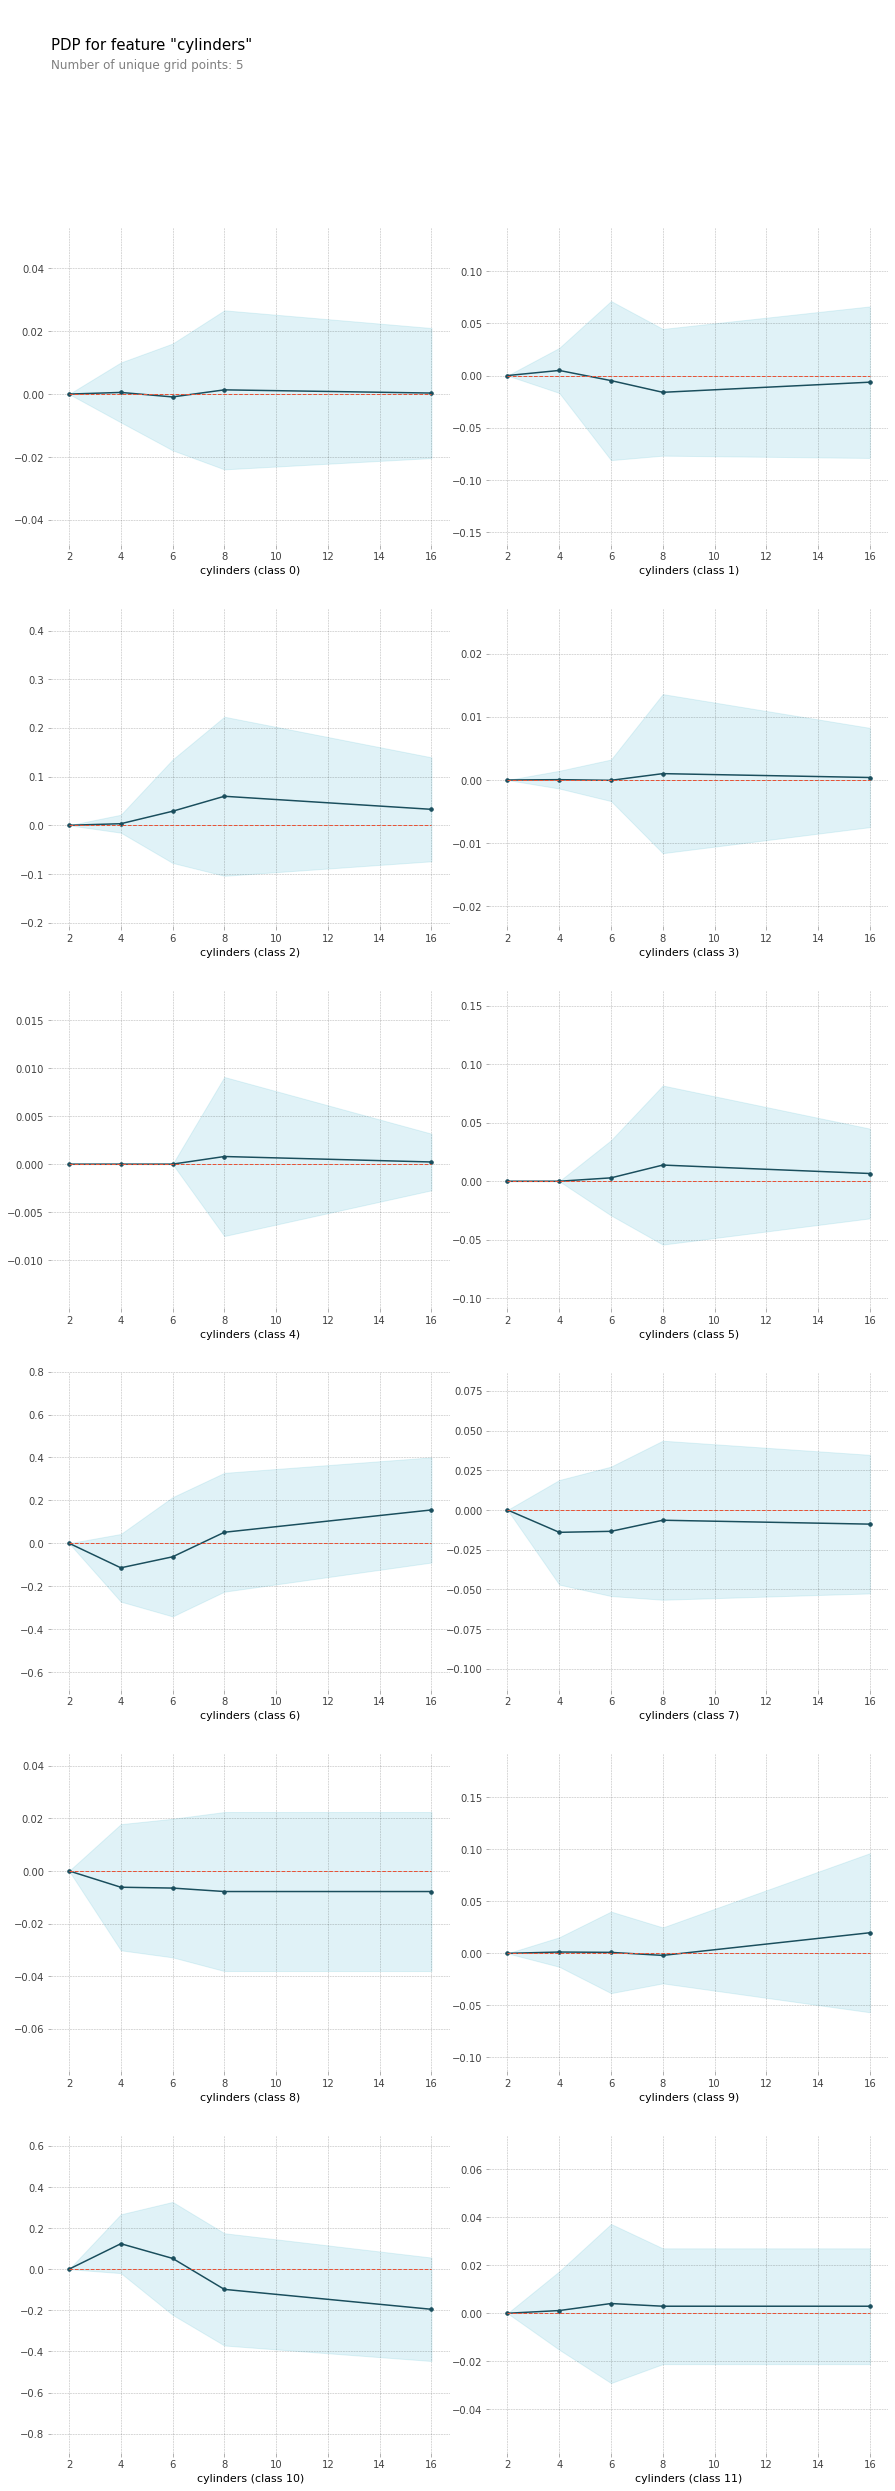

In [108]:
#PDP plot
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'cylinders'

isolate = pdp_isolate(
          model = model_rf,
          dataset=X_val,
          model_features = X_val.columns,
          feature= feature
)

pdp_plot(isolate, feature_name= feature);


(<Figure size 1080x3384 with 25 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f47d32f9350>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47d445b490>})

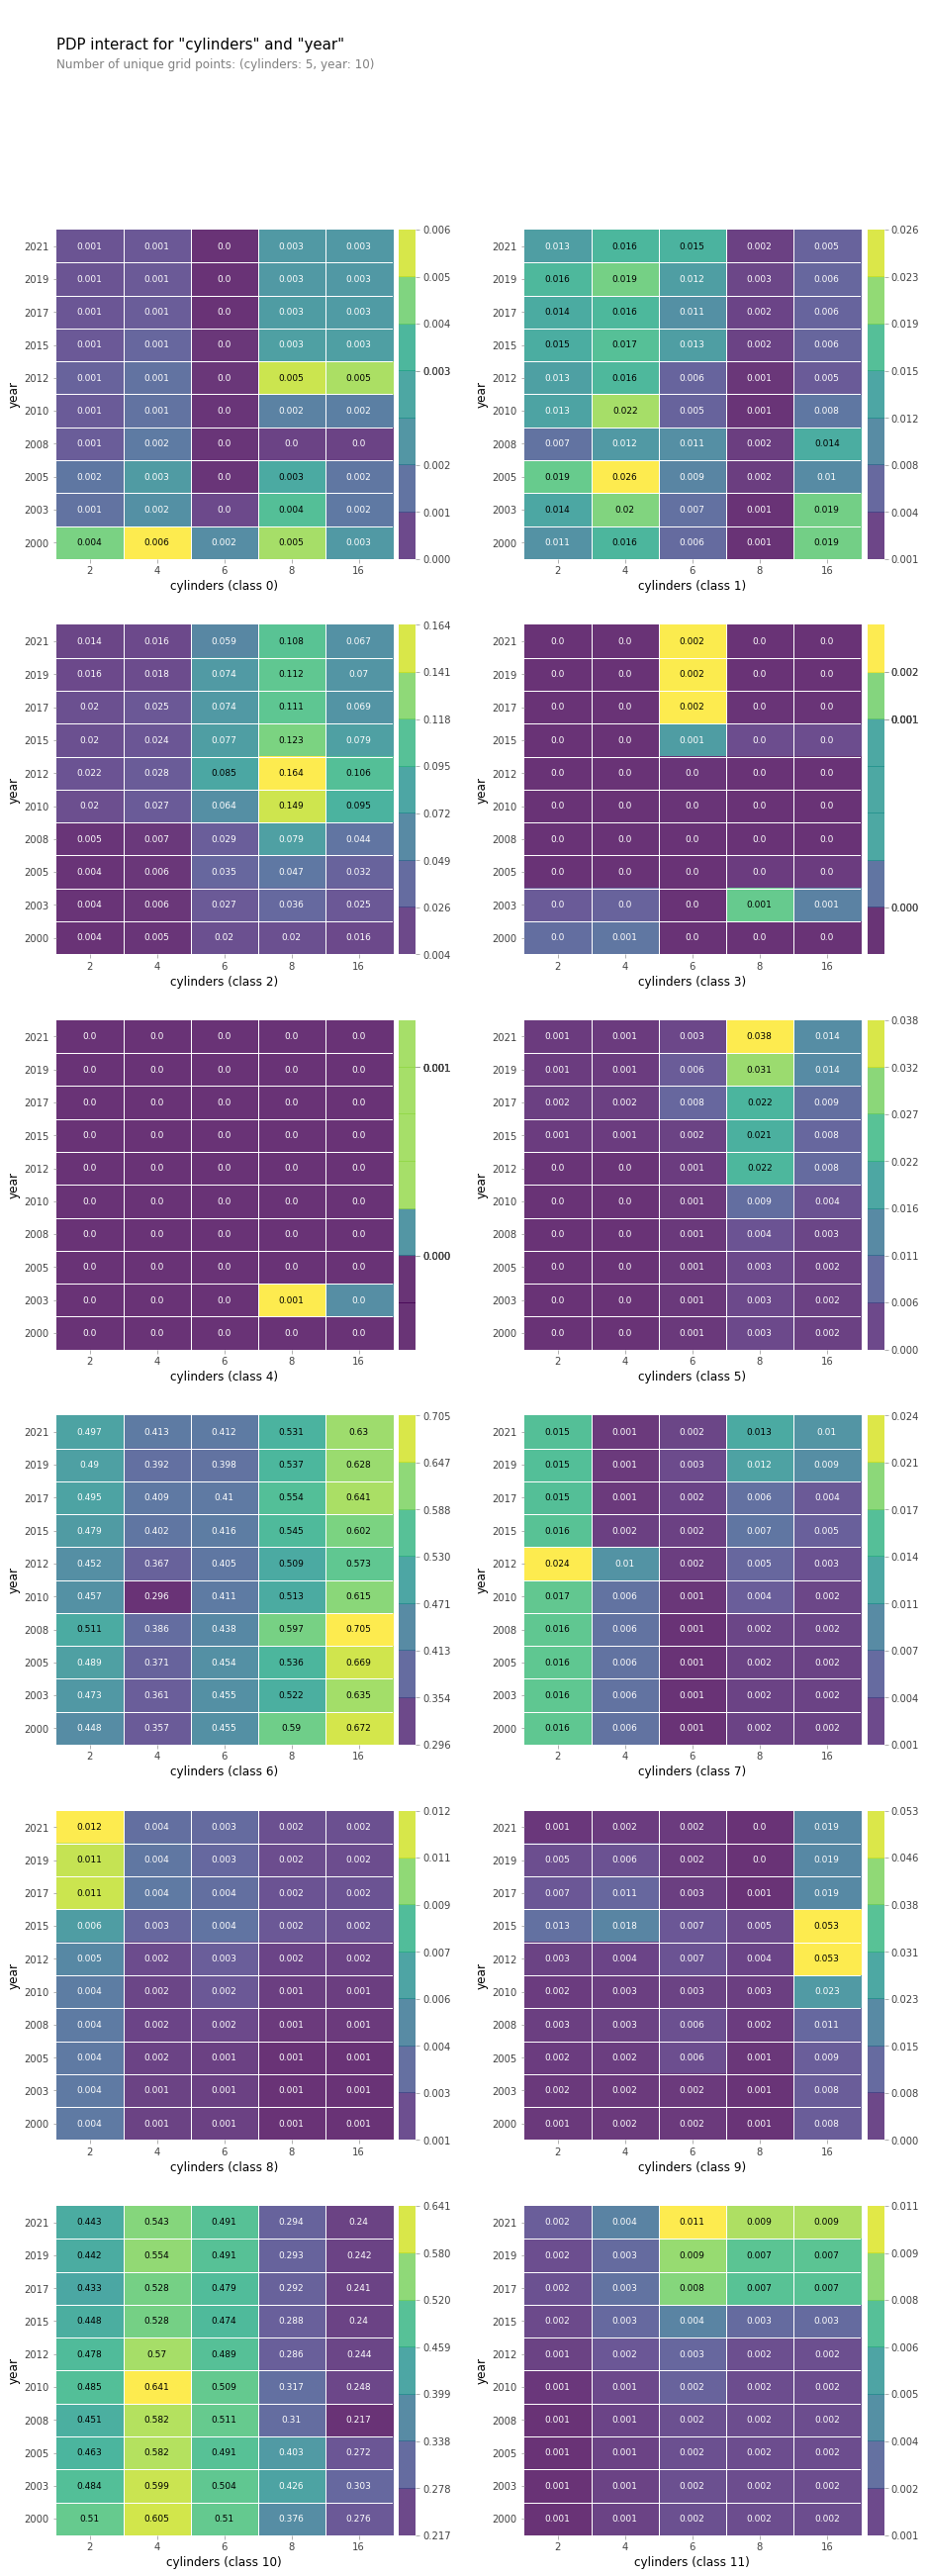

In [109]:
features = ['cylinders', 'year']

interact = pdp_interact(
    model= model_rf,
    dataset= X_val.dropna(),
    model_features= X_val.columns,
    features= features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features)